In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys

%store -r DISCO_ROOT_FOLDER
if "DISCO_ROOT_FOLDER" in globals():
    os.chdir(DISCO_ROOT_FOLDER)
    sys.path.append(DISCO_ROOT_FOLDER)

In [2]:
import numpy as np
from datasets.density_datasets import Datasets as DensityDatasets
from datasets.real_world_datasets import Datasets as RealWorldDatasets
from src.Evaluation.dcdistances.dctree import DCTree
from sklearn.cluster import DBSCAN
from src.Evaluation import disco_score, disco_samples

def disco_score_balanced(X, l):
    disco_values = disco_samples(X, l)
    disco_values_per_cluster = []
    for c in set(l):
        disco_values_per_cluster.append(disco_values[l==c].mean())
    return np.array(disco_values_per_cluster)

# dataset = DensityDatasets.complex9
# dataset = DensityDatasets.aggregation
dataset = RealWorldDatasets.Synth_high
X, l = dataset.standardized_data_cached

ks = range(2, 21)
dctree = DCTree(X, min_points=5, min_points_mr=2)
eps_list = [dctree.get_eps_for_k(k) for k in ks]
kcenter_labels = [dctree.get_k_center(k) for k in ks]
dbscan_labels = [DBSCAN(eps).fit(X).labels_ for eps in eps_list]

# kcenter_disco_results = [disco_score(X, l_) for l_ in kcenter_labels]
# dbscan_disco_results = [disco_score(X, l_) for l_ in dbscan_labels]

In [3]:
kcenter_datasets = [[(X, kcenter_labels[i])] for i, k in enumerate(ks)]
dbscan_datasets = [[(X, dbscan_labels[i])] for i, k in enumerate(ks)]

In [4]:
import pandas as pd
import glob

path = "results/find_dbscan_eps/"
dataframes = [pd.read_csv(path) for path in glob.glob(f"{path}*/*")]
df_ = pd.concat(dataframes).rename(columns={"function": "measure"})
df_["dataset"] = df_["dataset"].apply(lambda val: int(val.split("_")[-1]))
# df_["dataset"] = df_["dataset"].apply(lambda val: eps_list[val-2])
eval_results = df_.to_dict(orient="list")

In [5]:
from src.utils.metrics import create_and_rescale_df

df = create_and_rescale_df(eval_results)

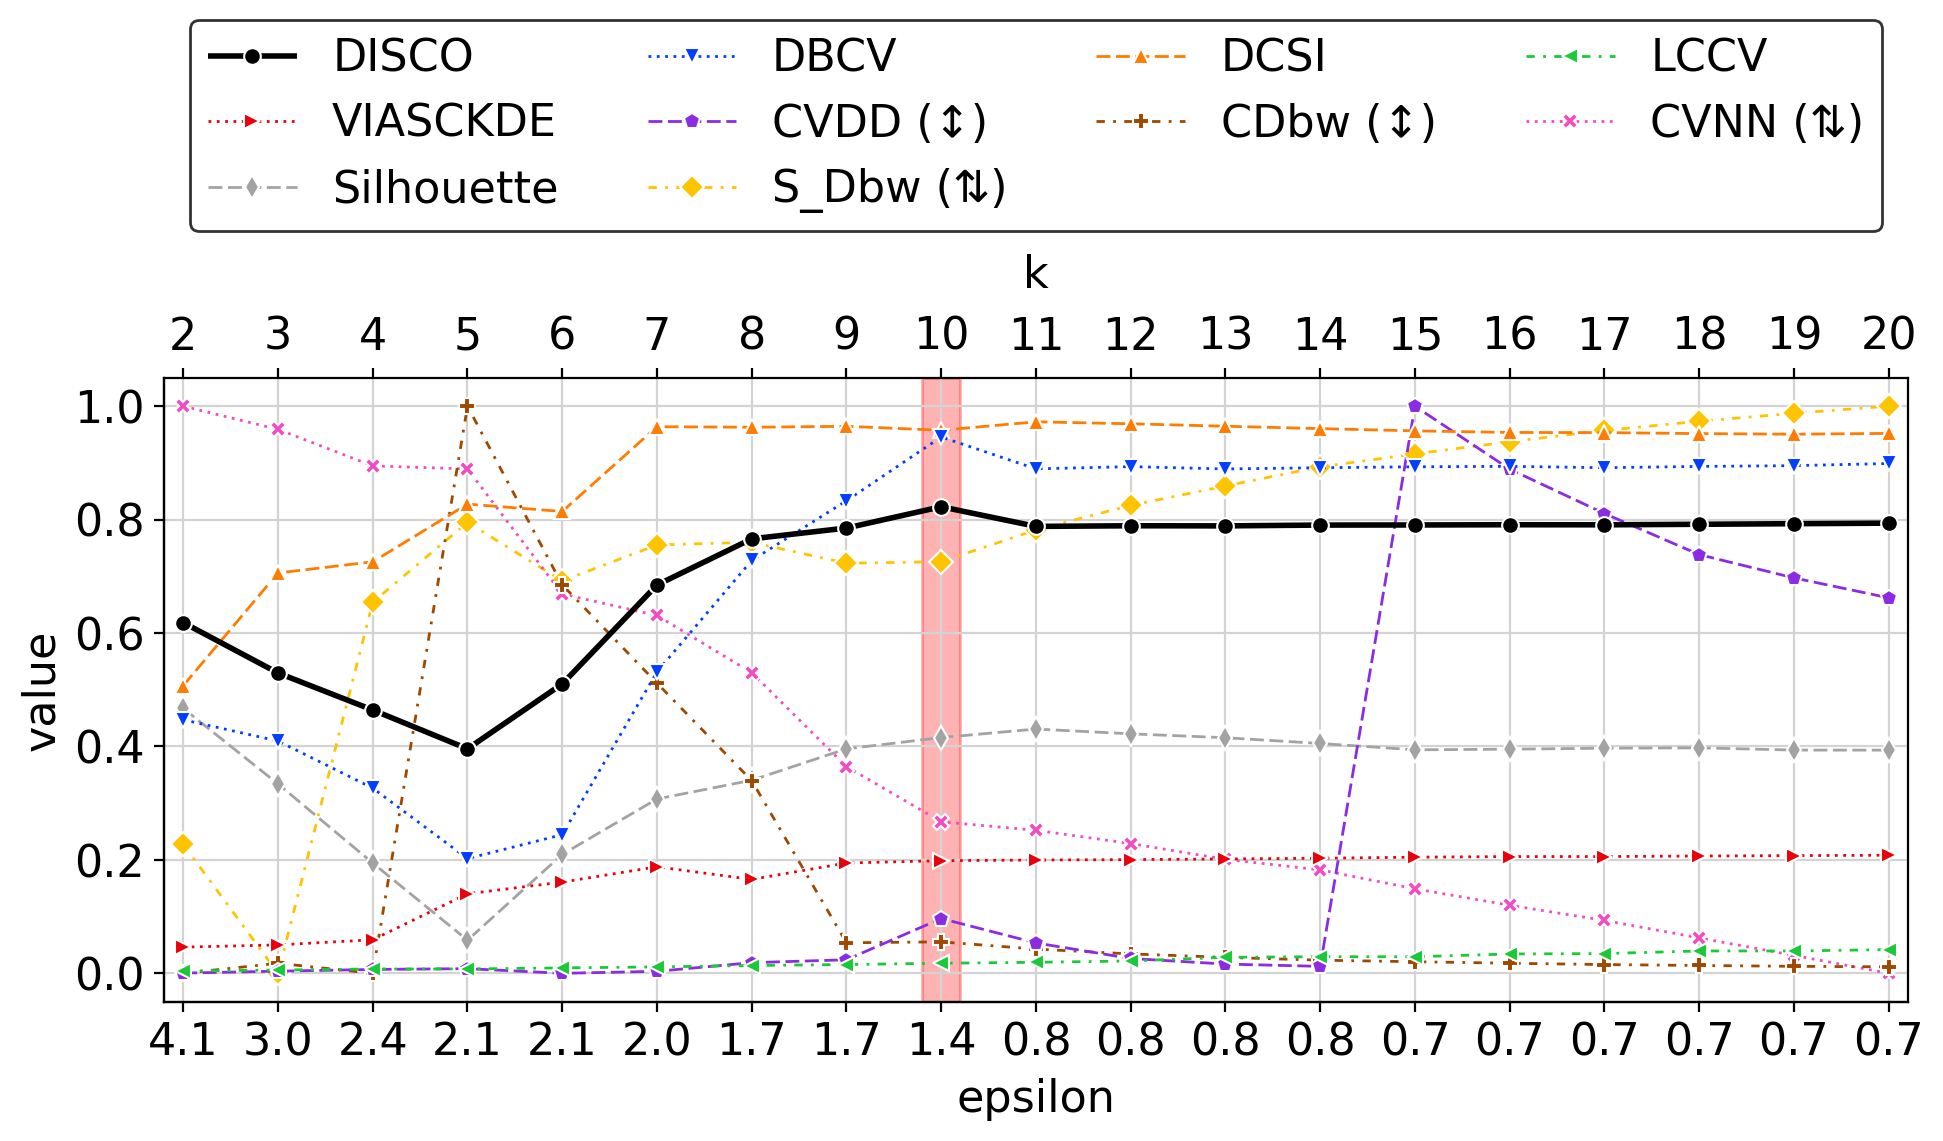

In [6]:
import matplotlib.pyplot as plt
from src.utils.plots import plot_lineplot

eps = 0.2
x_range = ks[0] - eps, ks[-1] + eps

fig = plot_lineplot(df, "dataset", "value", "measure", x_label="epsilon", x_range=x_range, y_range=(None, None))
ax1 = fig.axes[0]
ax2 = ax1.twiny()
ax2.set_xlabel("k", labelpad=10)
ax2.set_xticks(ks)
ax2.set_xlim(*x_range)
# ax2.tick_params(axis="x", which="major", pad=15)

ax1.set_xlabel("epsilon", labelpad=5)

ax1.set_xticks(ks, labels=np.round(eps_list,1))
ax1.axvspan(9.8, 10.2, alpha=0.3, color="red")
ax1.get_legend().set_bbox_to_anchor((0.5, 1.20))
plt.savefig("imgs/find_eps_dbscan.png", bbox_inches="tight", pad_inches=0)

In [7]:
import pandas as pd
import glob

path = "results/find_kcenter_k/"
dataframes = [pd.read_csv(path) for path in glob.glob(f"{path}*/*")]
df_ = pd.concat(dataframes).rename(columns={"function": "measure"})
df_["dataset"] = df_["dataset"].apply(lambda val: int(val.split("_")[-1]))
eval_results = df_.to_dict(orient="list")

In [8]:
from src.utils.metrics import create_and_rescale_df

df = create_and_rescale_df(eval_results)

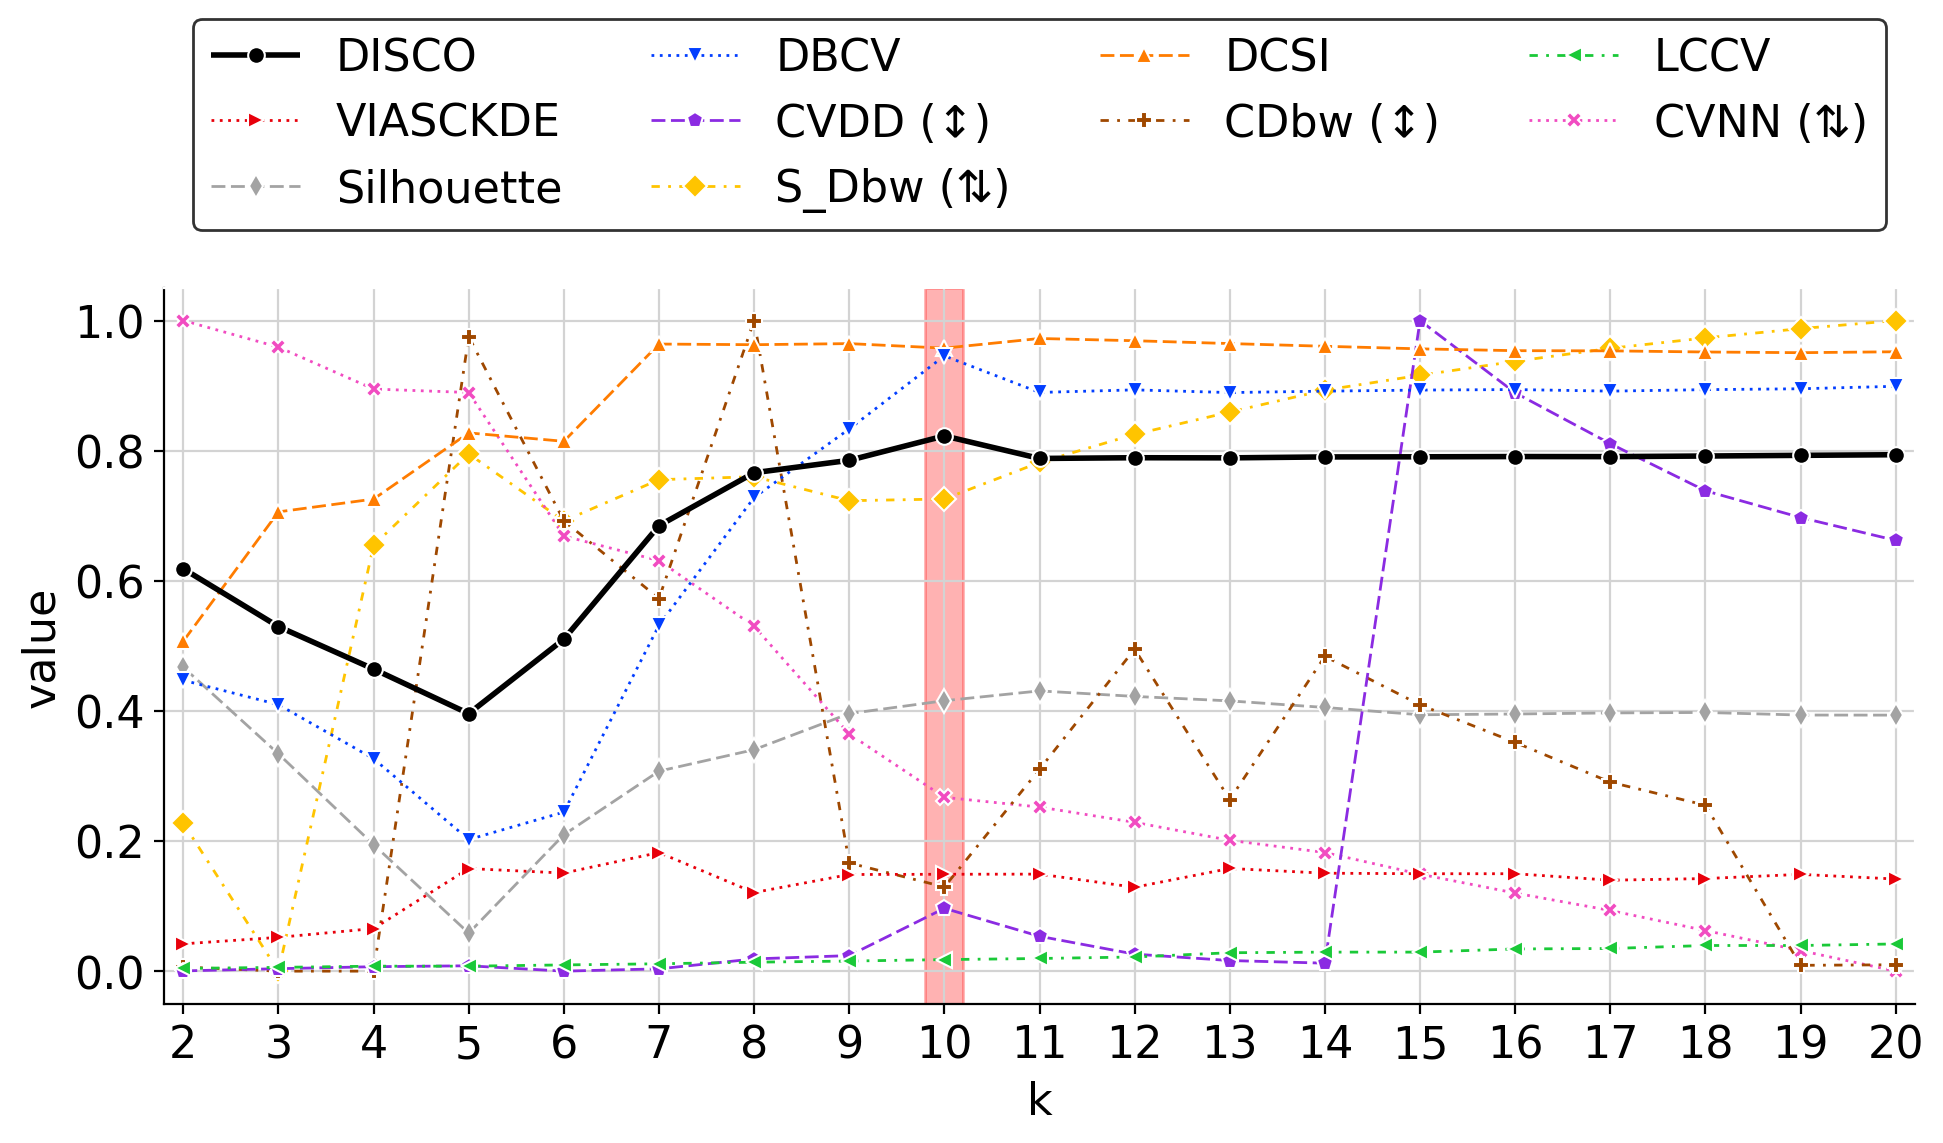

In [9]:
import matplotlib.pyplot as plt
from src.utils.plots import plot_lineplot

eps = 0.2
x_range = ks[0] - eps, ks[-1] + eps

fig = plot_lineplot(df, "dataset", "value", "measure", x_label="k", x_range=x_range, y_range=(None, None))
ax1 = fig.axes[0]
# ax2 = ax1.twiny()
# ax2.set_xlabel("k", labelpad=10)
# ax2.set_xticks(ks)
# ax2.set_xlim(*x_range)
# ax2.tick_params(axis="x", which="major", pad=15)

ax1.set_xlabel("k", labelpad=5)
ax1.set_xticks(ks)
ax1.axvspan(9.8, 10.2, alpha=0.3, color="red")
# ax1.get_legend().set_bbox_to_anchor((0.5, 1.20))
plt.savefig("imgs/find_k_kcenter.png", bbox_inches="tight", pad_inches=0)

In [18]:
print("kcenter_k:", [len(set(l_)) for l_ in kcenter_labels])
print("dbscan_k:", [len(set(l_)) for l_ in dbscan_labels])

kcenter_k: [2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
dbscan_k: [2, 3, 4, 5, 27, 27, 28, 32, 32, 38, 38, 36, 39, 39, 38, 36, 35, 33, 34]


In [19]:
kcenter_disco_results = [disco_score(X, l_) for l_ in kcenter_labels]
dbscan_disco_results = [disco_score(X, l_) for l_ in dbscan_labels]

In [20]:
import pandas as pd

data_dict = {
    "k": ks,
    "eps": eps_list,
    "kcenter_disco": kcenter_disco_results,
    "dbscan_disco": dbscan_disco_results,
    "dataset": dataset.name,
}

df = pd.DataFrame(data_dict)

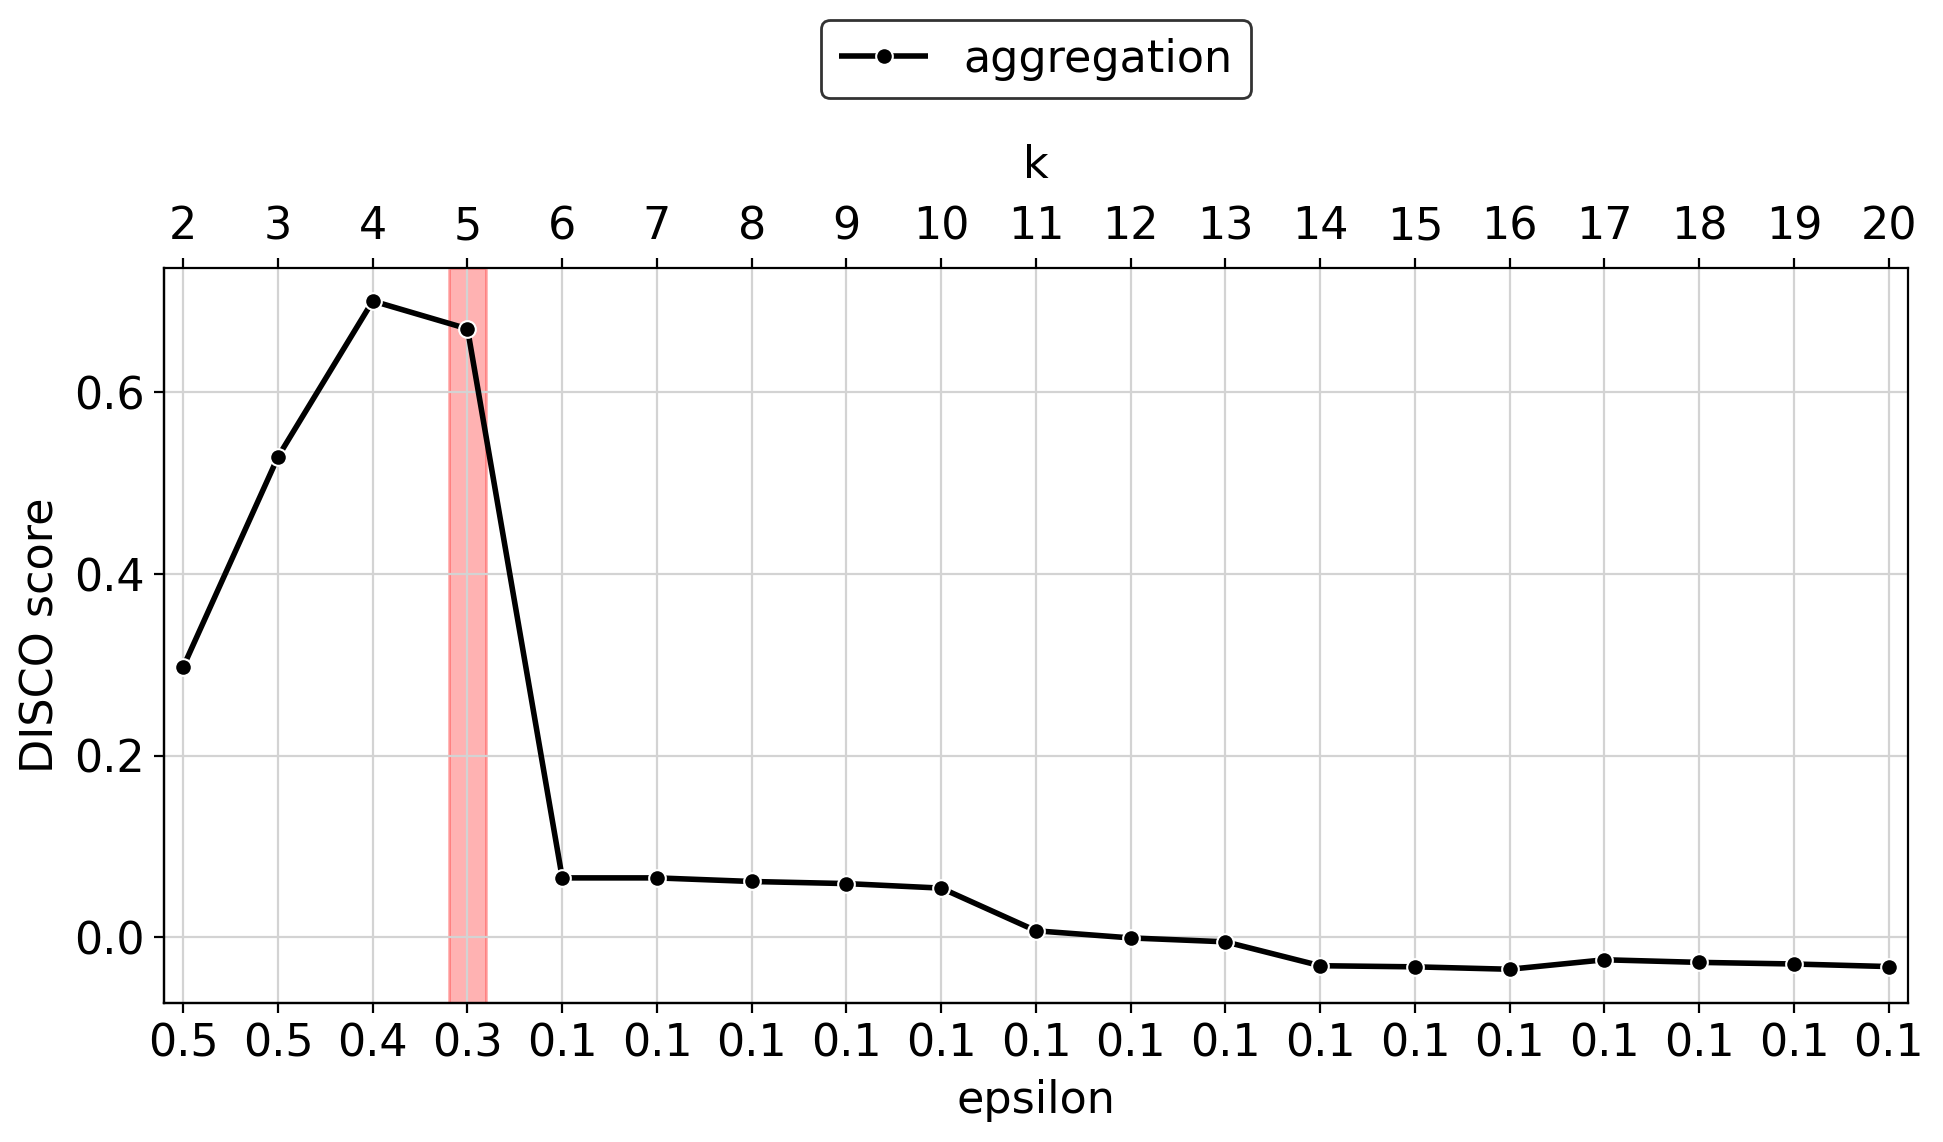

In [24]:
from src.utils.plots import plot_lineplot
import matplotlib.pyplot as plt

eps = 0.2
x_range = ks[0] - eps, ks[-1] + eps

fig = plot_lineplot(df, "k", "dbscan_disco", "dataset", x_label="epsilon", y_label="DISCO score", x_range=x_range, y_range=(None, None), order=[dataset.name])
ax1 = fig.axes[0]
ax2 = ax1.twiny()
ax2.set_xlabel("k", labelpad=10)
ax2.set_xticks(ks)
ax2.set_xlim(*x_range)
# ax2.tick_params(axis="x", which="major", pad=15)

ax1.set_xlabel("epsilon", labelpad=5)

ax1.set_xticks(ks, labels=np.round(eps_list,1))
ax1.axvspan(4.8, 5.2, alpha=0.3, color="red")
ax1.get_legend().set_bbox_to_anchor((0.5, 1.20))
plt.savefig("imgs/aggregation_find_k_eps.png", bbox_inches="tight", pad_inches=0)
plt.show()

In [17]:
import matplotlib.colors as colors

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    return colors.LinearSegmentedColormap.from_list(
        "trunc({n},{a:.2f},{b:.2f})".format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)),
    )

cmap = truncate_colormap(plt.colormaps["gist_rainbow"], 0.0, 0.85)

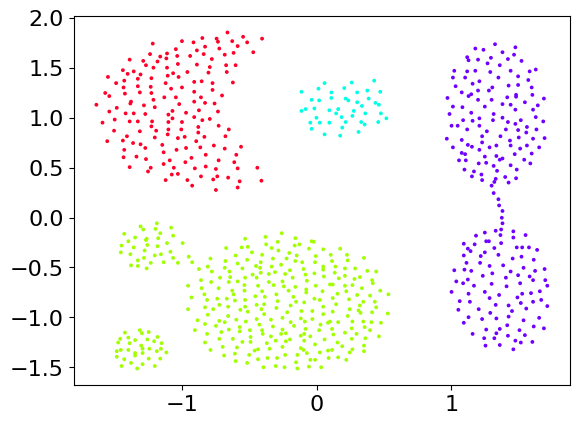

In [18]:
plt.scatter(X[:, 0], X[:, 1], s=3, c=kcenter_labels[np.argmax(kcenter_disco_results)], cmap=cmap)
plt.show()

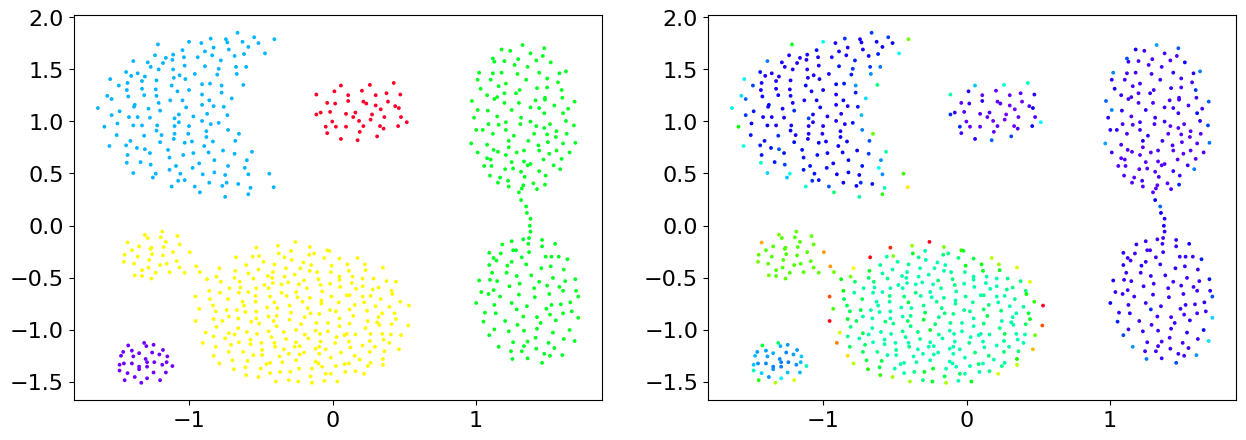

In [49]:
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.scatter(X[:, 0], X[:, 1], s=3, c=kcenter_labels[3], cmap=cmap)
plt.subplot(1, 2, 2)
plt.scatter(X[:, 0], X[:, 1], s=3, c=disco_samples(X, kcenter_labels[3]), cmap=cmap)
plt.show()

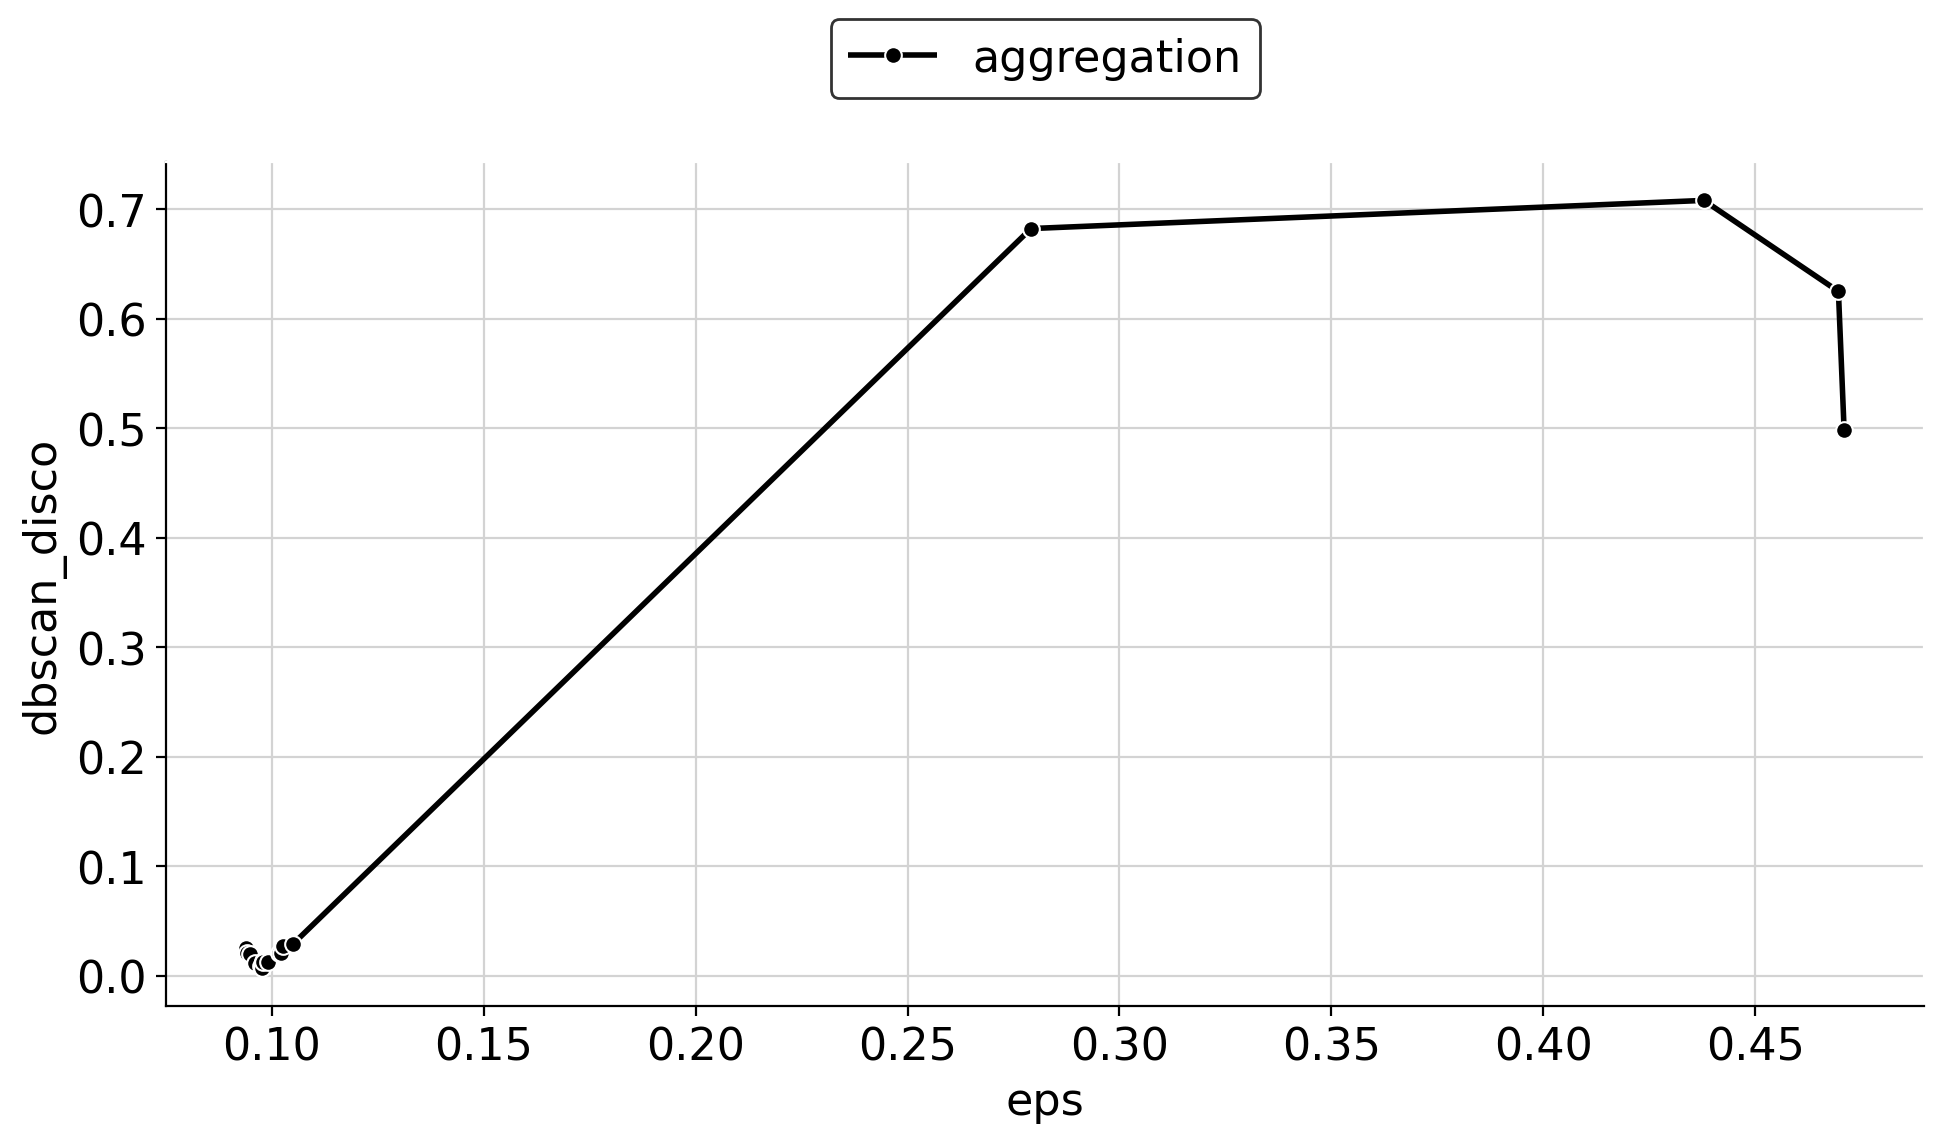

In [ ]:
from src.utils.plots import plot_lineplot
import matplotlib.pyplot as plt

eps = 1
x_range = None, None

plot_lineplot(df, "eps", "dbscan_disco", "dataset", x_range=x_range, y_range=(None, None), order=[dataset.name])
plt.savefig("imgs/Synth_high_find_eps.png", bbox_inches="tight", pad_inches=0)
plt.show()

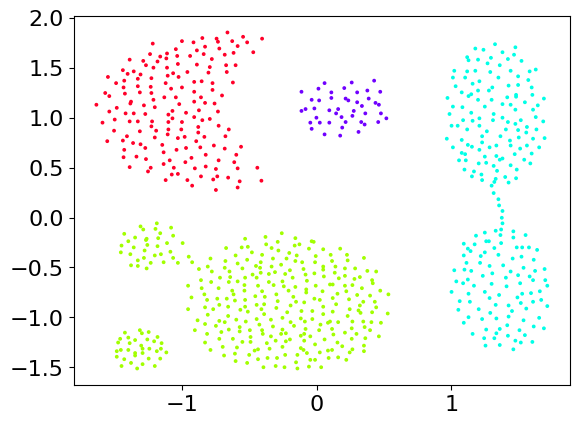

In [20]:
plt.scatter(X[:, 0], X[:, 1], s=3, c=dbscan_labels[np.argmax(dbscan_disco_results)], cmap=cmap)
plt.show()

In [52]:
import numpy as np 

l__ = np.random.choice(170, len(l))
print(f"Nr of Clusters: {len(set(l__))}, DISCO: {disco_score(X, l__)}")

Nr of Clusters: 168, DISCO: -0.6228814662690386


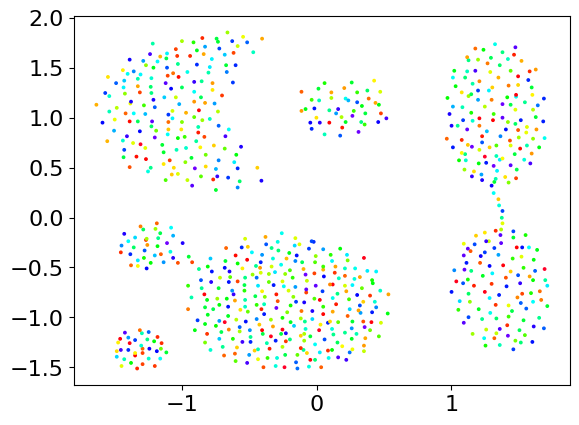

In [53]:
plt.scatter(X[:, 0], X[:, 1], s=3, c=l__, cmap=cmap)
plt.show()

In [54]:
from src.Evaluation import disco_score
import numpy as np

ks = np.array([range(1, 300) for j in range(10)]).flatten()

np.random.seed(0)

ls = [np.random.choice(i, len(l)) for i in ks]
disco_values = [disco_score(X, l) for l in ls]

In [62]:
results = np.hstack((np.array(ls), ks[:, np.newaxis], np.array(disco_values)[:, np.newaxis]))
np.save(".cache/increasing_labelset.npy", results)

In [67]:
results = np.load(".cache/increasing_labelset.npy")
ls = results[:, :-2]
ks = results[:, -2]
disco_values = results[:, -1]

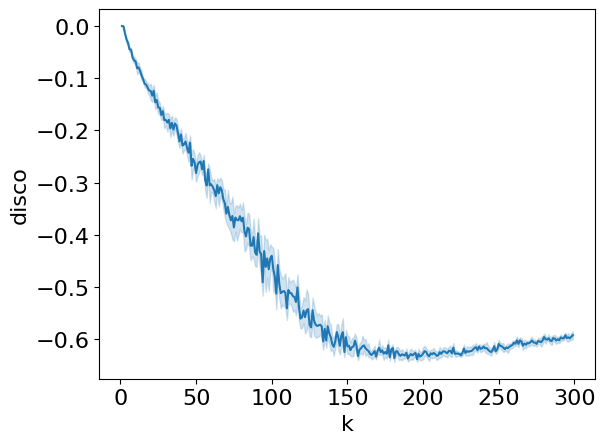

In [70]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

data_dict = {
    "k": ks,
    "disco": disco_values,
}
df = pd.DataFrame(data_dict)

sns.lineplot(df, x="k", y="disco")
plt.show()